In [ ]:
def forecast(
    self,
    x_input: np.ndarray,
    y_period: int,
    *,
    draw_z: bool = True,
    quantiles=(5, 50, 95),
) -> ForecastOutput:
    """Generate multi-step forecast using fitted CCC-GARCH model."""

    if not self.is_calibrated:
        raise ValueError("Model must be calibrated before forecasting")

    if not hasattr(self, 'idata') or not hasattr(self, 'pivot_data'):
        # Fallback to simple approach
        return ForecastOutput(y_hat=[[0.0] * len(self.y_features)] * y_period)

    try:
        # ---- Build the history used by the simulator ------------------------
        # Accept x_input as: (K, n) additional observations after calibration
        x_input = np.asarray(x_input, dtype=float)
        if x_input.ndim == 1:
            x_input = x_input[np.newaxis, :]

        # Scale to model’s internal units
        scale = getattr(self, "data_scale", 1.0)
        x_input_scaled = x_input / scale

        # Use training history + any new rows as simulator seed
        # self.x_full was stored at calibrate time (already scaled)
        X_hist = self.x_full
        if x_input_scaled.size > 0:
            X_hist = np.vstack([self.x_full, x_input_scaled])

        # ---- Simulate without premature averaging ---------------------------
        forecasts, mu_last, sigma_last = self._simulate_ccc_garch_paths(
            self.idata,
            X_hist,
            steps=y_period,
            draw_z=draw_z,
            seed=123,
            rescale=True,  # bring back to original scale
        )
        # forecasts: (steps, S, n) in original scale

        if forecasts is None or forecasts.shape[0] == 0:
            y_hat = [[0.0] * len(self.y_features)] * y_period
            return ForecastOutput(y_hat=y_hat)

        # ---- Summaries AFTER simulation -------------------------------------
        mean_path = forecasts.mean(axis=1)  # (steps, n)
        qs = {q: np.percentile(forecasts, q, axis=1) for q in quantiles}  # dict[q] -> (steps, n)

        # Keep your expected format: List[List[float]]
        y_hat = [mean_path[t].tolist() for t in range(y_period)]

        # If your ForecastOutput supports extra fields, attach intervals
        extras = dict(
            quantiles={int(q): qs[q].tolist() for q in quantiles},  # (steps, n) per quantile
        )

        return ForecastOutput(y_hat=y_hat, extras=extras)  # drop extras if your class doesn’t allow it

    except Exception as e:
        print(f"Forecast generation failed: {e}")
        return ForecastOutput(y_hat=[[0.0] * len(self.y_features)] * y_period)


In [ ]:
def evaluate(
    self,
    x_test: np.ndarray,
    y_test: np.ndarray,
    *_, **__
) -> ForecastEvaluationOutput:
    """Evaluate multi-step forecast accuracy against y_test."""

    if not self.is_calibrated:
        raise ValueError("Model must be calibrated before evaluation")

    # y_test expected shape: (H, n)
    y_test = np.asarray(y_test, dtype=float)
    if y_test.ndim == 1:
        y_test = y_test[np.newaxis, :]

    H, n = y_test.shape

    # Produce H-step forecast starting from x_test
    fcst = self.forecast(x_test, H, draw_z=True)
    y_hat = np.asarray(fcst.y_hat, dtype=float)  # (H, n)

    if y_hat.shape != y_test.shape:
        raise ValueError(f"Shape mismatch: forecast {y_hat.shape} vs y_test {y_test.shape}")

    # NaN-safe RMSE
    diff = y_hat - y_test
    mask = np.isfinite(diff)
    if not np.any(mask):
        rmse = 999.0
        per_series_rmse = [999.0] * n
    else:
        rmse = np.sqrt(np.nanmean((diff[mask]) ** 2))
        per_series_rmse = np.sqrt(np.nanmean((diff) ** 2, axis=0)).tolist()

    return ForecastEvaluationOutput(
        y_hat=y_hat.tolist(),
        error_type=ErrorType.RMSE,
        error_value=rmse,
        extras={"per_series_rmse": per_series_rmse}
    )


In [ ]:
def plot_forecast_fanchart(self, forecast_output: ForecastOutput, series_index: int = 0, title=None, savepath=None):
    import matplotlib.pyplot as plt
    qs = forecast_output.extras.get("quantiles", None) if hasattr(forecast_output, "extras") else None
    y_hat = np.asarray(forecast_output.y_hat)

    H = y_hat.shape[0]
    x_axis = np.arange(1, H + 1)

    plt.figure(figsize=(8, 4.5))
    plt.plot(x_axis, y_hat[:, series_index], label="Mean forecast")

    if qs is not None:
        q5  = np.asarray(qs[5])[:, series_index]
        q95 = np.asarray(qs[95])[:, series_index]
        plt.fill_between(x_axis, q5, q95, alpha=0.25, label="90% PI")

    plt.xlabel("Horizon")
    plt.ylabel(f"Series {series_index}")
    plt.title(title or "CCC-GARCH Forecast")
    plt.legend()
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=150, bbox_inches="tight")
    plt.close()


In [ ]:
def plot_in_sample_fit(self, idata, y_true, series_names=None):
    """Plot actual vs fitted values (posterior mean) for in-sample data."""
    mu_hat = idata.posterior['mu'].mean(dim=["chain", "draw"]).values
    sigma_hat = idata.posterior['sigma'].mean(dim=["chain", "draw"]).values
    
    n_obs, n_series = y_true.shape
    if series_names is None:
        series_names = [f"Series {i+1}" for i in range(n_series)]

    fig, axes = plt.subplots(n_series, 1, figsize=(12, 4*n_series), sharex=True)
    if n_series == 1:
        axes = [axes]

    for j in range(n_series):
        axes[j].plot(y_true[:, j], label="Observed", color="black")
        axes[j].plot(mu_hat[:, j], label="Fitted mean", color="red")
        axes[j].fill_between(
            range(n_obs),
            mu_hat[:, j] - 2 * sigma_hat[:, j],
            mu_hat[:, j] + 2 * sigma_hat[:, j],
            color="red", alpha=0.2, label="±2σ"
        )
        axes[j].set_title(f"In-sample fit: {series_names[j]}")
        axes[j].legend()

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_forecast(self, forecasts, y_test=None, series_names=None):
    """Fan chart for CCC-GARCH forecasts."""
    n_steps, n_series = forecasts.shape[0], forecasts.shape[2]
    if series_names is None:
        series_names = [f"Series {i+1}" for i in range(n_series)]

    fig, axes = plt.subplots(n_series, 1, figsize=(12, 4*n_series), sharex=True)
    if n_series == 1:
        axes = [axes]

    for j in range(n_series):
        forecast_dist = forecasts[:, :, j]  # shape (steps, draws)
        p5, p50, p95 = np.percentile(forecast_dist, [5, 50, 95], axis=1)

        axes[j].plot(p50, label="Forecast median", color="blue")
        axes[j].fill_between(range(n_steps), p5, p95, color="blue", alpha=0.2, label="90% CI")
        if y_test is not None:
            axes[j].plot(y_test[:, j], label="Actual future", color="black")

        axes[j].set_title(f"Forecast: {series_names[j]}")
        axes[j].legend()

    plt.tight_layout()
    plt.show()


In [ ]:
import arviz as az

# Plot fitted mu vs observed
mu_post = idata.posterior["mu"].mean(dim=("chain","draw"))
sigma_post = idata.posterior["sigma"].mean(dim=("chain","draw"))

plt.plot(Y[:,0], label="Observed series 1")
plt.plot(mu_post[:,0], label="Fitted mean")
plt.fill_between(range(len(Y)),
                 mu_post[:,0]-2*sigma_post[:,0],
                 mu_post[:,0]+2*sigma_post[:,0],
                 alpha=0.2, label="±2σ")
plt.legend()


In [ ]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Dict, Any, Tuple
import numpy as np
import pandas as pd
from numpy.linalg import inv, slogdet
from scipy.optimize import minimize

# ----------------------- univariate AR(5)-GARCH(1,1) ------------------------

def _ar5_mean(c: float, phi: np.ndarray, y: np.ndarray) -> np.ndarray:
    T = y.shape[0]
    mu = np.empty(T)
    mu[:5] = c
    for t in range(5, T):
        mu[t] = c + phi @ y[t-1:t-6:-1]
    return mu

def _garch11_var(omega: float, alpha: float, beta: float, eps: np.ndarray) -> np.ndarray:
    T = eps.shape[0]
    h = np.empty(T)
    denom = max(1e-6, 1.0 - alpha - beta)
    h[0] = max(1e-8, omega / denom)
    for t in range(1, T):
        h[t] = omega + alpha * eps[t-1]**2 + beta * h[t-1]
        if h[t] < 1e-12:
            h[t] = 1e-12
    return h

def _uv_nll(theta: np.ndarray, y: np.ndarray) -> float:
    # theta = [c, omega, alpha, beta, phi1..phi5]
    c, omega, alpha, beta = theta[0], theta[1], theta[2], theta[3]
    phi = theta[4:9]

    # bounds/penalties for stability
    if omega <= 0 or alpha < 0 or beta < 0 or alpha + beta >= 0.9999:
        return 1e12

    mu = _ar5_mean(c, phi, y)
    eps = y - mu
    h = _garch11_var(omega, alpha, beta, eps)

    t0 = 5
    e = eps[t0:]
    ht = h[t0:]
    # Gaussian QMLE (drop constants)
    nll = 0.5 * (np.log(ht).sum() + (e**2 / ht).sum())
    return nll if np.isfinite(nll) else 1e12

def _fit_univariate(y: np.ndarray) -> Dict[str, Any]:
    # crude initials
    c0 = 0.0
    var = np.var(y, ddof=1)
    omega0 = 0.05 * var if var > 0 else 1e-6
    alpha0, beta0 = 0.05, 0.9
    phi0 = np.zeros(5)
    theta0 = np.r_[c0, omega0, alpha0, beta0, phi0]

    bounds = [(None, None),          # c
              (1e-10, None),         # omega
              (1e-8, 0.999),         # alpha
              (1e-8, 0.999)] + [(None, None)]*5  # phi1..phi5

    res = minimize(_uv_nll, theta0, args=(y,),
                   method="L-BFGS-B", bounds=bounds,
                   options={"maxiter": 5000, "ftol": 1e-9})

    th = res.x
    c, omega, alpha, beta = th[0], th[1], th[2], th[3]
    phi = th[4:9]

    mu = _ar5_mean(c, phi, y)
    eps = y - mu
    h = _garch11_var(omega, alpha, beta, eps)

    out = {
        "success": res.success,
        "message": res.message,
        "nll": float(res.fun),
        "params": {"c": c, "omega": omega, "alpha": alpha, "beta": beta, "phi": phi},
        "mu": mu,                # (T,)
        "h": h,                  # (T,)
        "vol": np.sqrt(h),       # (T,)
        "eps": eps               # (T,)
    }
    return out

# ----------------------- CCC two-step wrapper -------------------------------

@dataclass
class CCCTwoStepResults:
    success: bool
    messages: list[str]
    univariate: list[Dict[str, Any]]
    R: np.ndarray                 # (N, N)
    std_resids: np.ndarray        # (T_eff, N)
    H: np.ndarray                 # (T_eff, N, N)
    cond_means: np.ndarray        # (T, N)
    cond_vars: np.ndarray         # (T, N)
    cond_vols: np.ndarray         # (T, N)
    T_eff: int
    start_index: int
    loglike_full: float           # multivariate (concentrated) log-likelihood (up to const)

class CCCGARCHTwoStep:
    """
    Classic CCC-GARCH with two-step calibration:
      Step 1: Fit AR(5)-GARCH(1,1) per series (QMLE).
      Step 2: Standardize residuals, set R = sample correlation(Z).
              Build H_t = D_t R D_t and compute multivariate log-likelihood.
    """

    def __init__(self) -> None:
        self.assets: list[str] = []
        self.dates: pd.Index | None = None
        self.Y: np.ndarray | None = None
        self.T: int | None = None
        self.N: int | None = None
        self.result_: CCCTwoStepResults | None = None

    def spec(self, returns: pd.DataFrame) -> None:
        self.assets = list(returns.columns)
        self.dates = returns.index
        self.Y = returns.to_numpy(float)
        self.T, self.N = self.Y.shape

    @staticmethod
    def _safe_corr(Z: np.ndarray, eps: float = 1e-6) -> np.ndarray:
        R = np.corrcoef(Z, rowvar=False)
        R = (1 - eps) * R + eps * np.eye(R.shape[0])  # SPD ridge
        return R

    def fit(self) -> CCCTwoStepResults:
        assert self.Y is not None, "Call .spec(returns) first."
        T, N = self.T, self.N
        t0 = 5  # burn-in due to AR(5)

        # Step 1: univariate fits
        uni = []
        for i in range(N):
            uni.append(_fit_univariate(self.Y[:, i]))

        MU = np.column_stack([u["mu"] for u in uni])     # (T, N)
        Hdiag = np.column_stack([u["h"] for u in uni])   # (T, N)
        VOL = np.sqrt(Hdiag)
        EPS = self.Y - MU

        # Step 2: CCC — standardized residuals and correlation
        Z = EPS[t0:, :] / VOL[t0:, :]
        R = self._safe_corr(Z)
        sign, logdetR = slogdet(R)
        if sign <= 0:
            raise RuntimeError("Correlation matrix not SPD.")

        # H_t for t >= t0
        Te = T - t0
        H = np.zeros((Te, N, N))
        for t in range(Te):
            Dt = np.diag(VOL[t0 + t, :])
            H[t] = Dt @ R @ Dt

        # (Concentrated) multivariate Gaussian log-likelihood (up to constants)
        # sum_t [ -0.5*( log|H_t| + e_t' H_t^{-1} e_t ) ]
        # with log|H_t| = sum_i log h_{i,t} + log|R|
        logh_sum = np.log(Hdiag[t0:, :]).sum()
        quad = 0.0
        Rinv = inv(R)
        for t in range(Te):
            zt = Z[t, :]
            quad += zt @ Rinv @ zt
        ll = -0.5 * (Te * logdetR + logh_sum + quad)

        self.result_ = CCCTwoStepResults(
            success=all(u["success"] for u in uni),
            messages=[u["message"] for u in uni],
            univariate=uni,
            R=R,
            std_resids=Z,
            H=H,
            cond_means=MU,
            cond_vars=Hdiag,
            cond_vols=VOL,
            T_eff=Te,
            start_index=t0,
            loglike_full=float(ll),
        )
        return self.result_

    def forecast(self, n_ahead: int = 1) -> Dict[str, np.ndarray]:
        """
        Mean-path forecasts:
          mu_{t+k|t}: iterate AR(5) using last observed y
          h_{t+k|t}: iterate GARCH(1,1) with eps_t^2, h_t from last time
          R is constant (CCC)
          H_{t+k|t} = D_{t+k|t} R D_{t+k|t}
        """
        assert self.result_ is not None, "Fit the model first."
        Y = self.Y
        T, N = self.T, self.N
        p = 5
        R = self.result_.R

        Cs = np.array([u["params"]["c"] for u in self.result_.univariate])
        Om = np.array([u["params"]["omega"] for u in self.result_.univariate])
        Al = np.array([u["params"]["alpha"] for u in self.result_.univariate])
        Be = np.array([u["params"]["beta"] for u in self.result_.univariate])
        Ph = np.vstack([u["params"]["phi"] for u in self.result_.univariate])

        mu_hist = self.result_.cond_means
        h_hist  = self.result_.cond_vars
        eps_hist = Y - mu_hist

        mu_fc = np.zeros((n_ahead, N))
        var_fc = np.zeros((n_ahead, N))

        y_buf = Y.copy()
        h_t = h_hist[-1, :].copy()
        eps2_t = eps_hist[-1, :]**2

        for k in range(n_ahead):
            y_hist = y_buf[-p:, :]  # shape (5,N)
            for i in range(N):
                mu_fc[k, i] = Cs[i] + Ph[i] @ y_hist[::-1, i]
            var_fc[k, :] = Om + Al * eps2_t + Be * h_t
            # advance with mean path
            y_buf = np.vstack([y_buf, mu_fc[k, :]])
            eps2_t = 0.0 * eps2_t
            h_t = var_fc[k, :]

        vol_fc = np.sqrt(np.maximum(var_fc, 1e-12))
        cov_fc = np.zeros((n_ahead, N, N))
        for k in range(n_ahead):
            Dk = np.diag(vol_fc[k, :])
            cov_fc[k] = Dk @ R @ Dk

        return {"mu": mu_fc, "var": var_fc, "vol": vol_fc, "cov": cov_fc, "R": R}


In [ ]:
# ruff: noqa: N806
from __future__ import annotations

from typing import TYPE_CHECKING, Tuple

import numpy as np
import pandas as pd
from numpy.linalg import LinAlgError
from scipy.optimize import minimize
from scipy.linalg import cholesky, cho_solve

if TYPE_CHECKING:
    pass


class DCCGARCHFullMLE:
    """
    Full-information MLE for DCC-GARCH with AR(5)-GARCH(1,1) margins.

    Fits AR(5) + GARCH(1,1) parameters for each asset and DCC (a,b)
    in one joint optimization by minimizing the entire multivariate
    Gaussian negative log-likelihood.
    """

    def __init__(self, eps_sum: float = 1e-4, eps_dcc: float = 1e-4, ar_stability_weight: float = 10.0):
        # data
        self.assets: list[str] = []
        self.dates: pd.Index | None = None
        self._returns: np.ndarray | None = None
        self.n_periods: int | None = None
        self.n_assets: int | None = None
        self.p_ar: int = 5

        # fitted time-varying stuff
        self.cond_means: np.ndarray | None = None       # (T, N)
        self.resids: np.ndarray | None = None           # (T, N)
        self.cond_vols: np.ndarray | None = None        # (T, N)
        self.std_resids: np.ndarray | None = None       # (T, N)
        self.cond_cor: np.ndarray | None = None         # (N, N, T)
        self.cond_cov: np.ndarray | None = None         # (N, N, T)

        # parameters (after fit)
        self.ar_params: np.ndarray | None = None        # (N, 1 + p) -> [c, phi1..phi5]
        self.garch_params: np.ndarray | None = None     # (N, 3) -> [omega, alpha, beta]
        self.dcc_a: float | None = None
        self.dcc_b: float | None = None

        # reparam epsilons / penalties
        self._eps_sum = eps_sum
        self._eps_dcc = eps_dcc
        self._ar_stab_w = ar_stability_weight

    # ------------------------
    # Data plumbing
    # ------------------------
    @property
    def returns(self) -> np.ndarray:
        return self._returns

    @returns.setter
    def returns(self, returns: pd.DataFrame) -> None:
        self._returns = returns.to_numpy(dtype=float)
        self.assets = returns.columns.to_list()
        self.n_assets = len(self.assets)
        self.n_periods = len(returns)
        self.dates = returns.index

    def spec(self, returns: pd.DataFrame) -> None:
        """Load the data and prep dimensions."""
        self.returns = returns
        if self.p_ar >= self.n_periods:
            raise ValueError("Not enough observations for AR(5).")

    # ------------------------
    # Helpers: parameter pack/unpack with constraints
    # ------------------------
    @staticmethod
    def _inv_logit(x: np.ndarray) -> np.ndarray:
        return 1.0 / (1.0 + np.exp(-x))

    def _unpack_params(self, theta: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, float, float]:
        """
        Map raw vector to structured, *constrained* parameters.

        Per asset i:
          [c_i, phi_i1..phi_i5, log_omega_i, u_i, v_i]
            -> omega_i = exp(log_omega_i)
            -> alpha_i = (1-eps) * u_i
            -> beta_i  = (1-eps-alpha_i) * v_i

        DCC tail:
          [u_a, v_b]
            -> a = (1-eps_dcc) * u_a
            -> b = (1-eps_dcc - a) * v_b
        """
        N = self.n_assets
        p = self.p_ar
        num_per_asset = 1 + p + 3  # c + 5 phi + (log_omega, u, v)
        expected_len = N * num_per_asset + 2
        if theta.size != expected_len:
            raise ValueError(f"Parameter length mismatch (got {theta.size}, expected {expected_len}).")

        # Split
        block = theta[: N * num_per_asset].reshape(N, num_per_asset)
        tail = theta[N * num_per_asset :]

        c = block[:, 0]
        phis = block[:, 1 : 1 + p]                      # (N, 5)

        log_omega = block[:, 1 + p]
        u_alpha_raw = block[:, 2 + p]
        v_beta_raw = block[:, 3 + p]

        omega = np.exp(log_omega)
        u_alpha = self._inv_logit(u_alpha_raw)
        v_beta = self._inv_logit(v_beta_raw)

        alpha = (1.0 - self._eps_sum) * u_alpha
        beta = (1.0 - self._eps_sum - alpha) * v_beta

        # DCC params
        u_a = self._inv_logit(tail[0])
        v_b = self._inv_logit(tail[1])
        a = (1.0 - self._eps_dcc) * u_a
        b = (1.0 - self._eps_dcc - a) * v_b

        return c, phis, np.column_stack([omega, alpha, beta]), float(a), float(b)

    def _initial_theta(self) -> np.ndarray:
        """
        Simple, robust initial values:
          c=0, phi=0, omega from var*0.1, alpha≈0.05, beta≈0.9 (sum<1)
          DCC: a≈0.02, b≈0.95
        """
        N = self.n_assets
        p = self.p_ar
        num_per_asset = 1 + p + 3

        var = self._returns.var(axis=0, ddof=1)
        omega0 = np.maximum(1e-8, 0.1 * var)          # positive
        alpha0 = 0.05 * np.ones(N)
        beta0 = np.minimum(0.9, 0.94 - alpha0)        # keep sum < 0.99
        # invert transforms
        log_omega0 = np.log(omega0)
        # alpha = (1-eps)*u -> u = alpha/(1-eps)
        u_alpha0 = np.clip(alpha0 / (1.0 - self._eps_sum), 1e-6, 1 - 1e-6)
        v_beta0 = np.clip(beta0 / (1.0 - self._eps_sum - alpha0), 1e-6, 1 - 1e-6)
        u_alpha_raw0 = np.log(u_alpha0 / (1.0 - u_alpha0))
        v_beta_raw0 = np.log(v_beta0 / (1.0 - v_beta0))

        # AR starts at zero (including intercept)
        c0 = np.zeros(N)
        phis0 = np.zeros((N, p))

        block = np.column_stack([c0, phis0, log_omega0, u_alpha_raw0, v_beta_raw0])  # (N, 1+p+3)

        # DCC init: a=0.02, b=0.95
        a0, b0 = 0.02, 0.95
        u_a0 = np.clip(a0 / (1.0 - self._eps_dcc), 1e-6, 1 - 1e-6)
        v_b0 = np.clip(b0 / (1.0 - self._eps_dcc - a0), 1e-6, 1 - 1e-6)
        tail = np.array([
            np.log(u_a0 / (1.0 - u_a0)),
            np.log(v_b0 / (1.0 - v_b0)),
        ])

        return np.concatenate([block.reshape(-1), tail])

    # ------------------------
    # Core likelihood machinery
    # ------------------------
    def _compute_conditional_means(self, c: np.ndarray, phis: np.ndarray) -> np.ndarray:
        T, N = self.n_periods, self.n_assets
        p = self.p_ar
        r = self._returns
        mu = np.zeros((T, N), dtype=float)
        for t in range(p, T):
            # mu_t = c + sum_{k=1..p} phi_k * r_{t-k}
            mu[t, :] = c + np.sum(phis * r[t - np.arange(1, p + 1)[:, None], :].T[:, ::-1][:, ::-1], axis=1)
            # The above indexing keeps it simple & explicit.
            # Alternatively:
            # mu[t, :] = c + (phis * r[t-1:t-p-1:-1, :].T).sum(axis=1)
        # first p means remain 0 (condition on initial lags)
        return mu

    def _compute_garch_vols(self, resids: np.ndarray, gpars: np.ndarray) -> np.ndarray:
        """resids: (T,N) -> h: (T,N) using GARCH(1,1) recursion."""
        T, N = resids.shape
        h = np.zeros_like(resids)
        for i in range(N):
            omega, alpha, beta = gpars[i]
            # Start h[0] at unconditional variance as a stable default
            var0 = np.var(resids[:, i], ddof=1)
            h_t = omega + alpha * (resids[0, i] ** 2 if np.isfinite(resids[0, i]) else 0.0) + beta * max(var0, 1e-8)
            h[0, i] = max(h_t, 1e-10)
            for t in range(1, T):
                h[t, i] = omega + alpha * (resids[t - 1, i] ** 2) + beta * h[t - 1, i]
                if h[t, i] <= 1e-12:
                    h[t, i] = 1e-12  # numerical floor
        return h

    @staticmethod
    def _ar_stability_penalty(phis_row: np.ndarray) -> float:
        """Penalize if any AR root is inside unit circle."""
        # AR poly: 1 - phi1 z - ... - phi_p z^p
        coeffs = np.concatenate([[1.0], -phis_row])
        try:
            roots = np.roots(coeffs)
            min_mod = np.min(np.abs(roots)) if roots.size else 1.0
        except Exception:
            min_mod = 0.0
        if min_mod <= 1.0:
            return (1.0 - min_mod + 1e-6) ** 2
        return 0.0

    def _dcc_recursion(self, u: np.ndarray, a: float, b: float) -> Tuple[np.ndarray, np.ndarray]:
        """
        u: standardized residuals (T,N)
        returns: R (N,N,T), H (N,N,T) is built elsewhere using D
        """
        T, N = u.shape
        Qbar = np.cov(u.T, bias=False)
        Q = np.zeros((N, N, T))
        R = np.zeros_like(Q)
        # initialize with Qbar
        Q[:, :, 0] = Qbar
        for t in range(1, T):
            utm1 = u[t - 1][:, None]
            Q[:, :, t] = (1.0 - a - b) * Qbar + a * (utm1 @ utm1.T) + b * Q[:, :, t - 1]
        # Normalize to correlations
        for t in range(T):
            d = np.sqrt(np.clip(np.diag(Q[:, :, t]), 1e-12, np.inf))
            Dinv = np.diag(1.0 / d)
            R[:, :, t] = Dinv @ Q[:, :, t] @ Dinv
        return R, Q

    def _negloglik(self, theta: np.ndarray) -> float:
        try:
            c, phis, gpars, a, b = self._unpack_params(theta)
            # mild AR stability penalty across assets
            pen = self._ar_stab_w * sum(self._ar_stability_penalty(phis[i]) for i in range(self.n_assets))

            # conditional means and residuals
            mu = self._compute_conditional_means(c, phis)
            e = self._returns - mu
            # drop first p obs (conditioning)
            e = e[self.p_ar :, :]
            T_eff = e.shape[0]
            if T_eff <= 2:
                return 1e12

            # GARCH volatilities
            h = self._compute_garch_vols(e, gpars)  # (T_eff,N)
            u = e / np.sqrt(h)

            # DCC recursion -> correlations
            R, _ = self._dcc_recursion(u, a, b)

            # Build H_t = D_t R_t D_t and accumulate Gaussian nll
            nll = 0.0
            for t in range(T_eff):
                D = np.diag(np.sqrt(h[t, :]))
                H = D @ R[:, :, t] @ D

                # Cholesky for stability
                L = cholesky(H, lower=True, check_finite=False)
                # log |H| = 2 * sum log diag(L)
                logdet = 2.0 * np.sum(np.log(np.diag(L)))
                # quadratic form via solves
                q = cho_solve((L, True), e[t, :], check_finite=False)
                quad = float(e[t, :].T @ q)

                nll += 0.5 * (logdet + quad)

            return nll + pen
        except (FloatingPointError, LinAlgError, ValueError) as _:
            return 1e12

    # ------------------------
    # Public API
    # ------------------------
    def fit(self, options: dict | None = None) -> None:
        """
        Jointly estimate AR(5), GARCH(1,1) per asset and DCC (a,b)
        by minimizing the full negative log-likelihood.
        """
        if self._returns is None:
            raise RuntimeError("Call .spec(returns) first.")

        theta0 = self._initial_theta()
        result = minimize(
            fun=self._negloglik,
            x0=theta0,
            method="L-BFGS-B",
            options={"maxiter": 10_000, "disp": False, **(options or {})},
        )

        # unpack & store
        c, phis, gpars, a, b = self._unpack_params(result.x)
        self.ar_params = np.column_stack([c, phis])                # (N, 1+5)
        self.garch_params = gpars                                   # (N, 3)
        self.dcc_a, self.dcc_b = a, b

        # build full state with fitted params for later use / plotting
        mu_full = self._compute_conditional_means(c, phis)
        e_full = self._returns - mu_full
        e_eff = e_full[self.p_ar :, :]
        h_eff = self._compute_garch_vols(e_eff, gpars)
        u_eff = e_eff / np.sqrt(h_eff)
        R_eff, _ = self._dcc_recursion(u_eff, a, b)

        # store with original T alignment (pad first p with NaN)
        T, N = self.n_periods, self.n_assets
        self.cond_means = mu_full
        self.resids = np.full((T, N), np.nan)
        self.resids[self.p_ar :, :] = e_eff
        self.cond_vols = np.full((T, N), np.nan)
        self.cond_vols[self.p_ar :, :] = np.sqrt(h_eff)
        self.std_resids = np.full((T, N), np.nan)
        self.std_resids[self.p_ar :, :] = u_eff

        self.cond_cor = np.zeros((N, N, T))
        self.cond_cor[:, :, : self.p_ar] = np.nan
        self.cond_cor[:, :, self.p_ar :] = R_eff

        self.cond_cov = np.zeros((N, N, T))
        for t in range(T):
            if t < self.p_ar or not np.isfinite(self.cond_vols[t, :]).all():
                self.cond_cov[:, :, t] = np.nan
            else:
                D = np.diag(self.cond_vols[t, :])
                self.cond_cov[:, :, t] = D @ self.cond_cor[:, :, t] @ D

    # Compatibility helpers (names you used before)
    @property
    def phis(self) -> np.ndarray | None:  # shape (N, 5)
        return self.ar_params[:, 1:] if self.ar_params is not None else None

    @property
    def thetas(self) -> np.ndarray | None:
        # Keeping for compatibility: ARMA "thetas" were MA(1); here unused.
        return np.zeros_like(self.phis) if self.ar_params is not None else None

    def plot(self):
        """
        You can plug in your existing plotting routine.
        This class exposes:
          - self.cond_vols  (T,N)
          - self.cond_cor   (N,N,T)
          - self.assets, self.dates
        """
        import matplotlib.pyplot as plt
        import matplotlib.dates as mdates

        if self.cond_vols is None or self.cond_cor is None:
            raise RuntimeError("Fit the model first.")

        N = self.n_assets
        fig, axes = plt.subplots(nrows=N, ncols=N, figsize=(9, 6), sharex=True)
        fig.tight_layout()
        plt.subplots_adjust(left=0.05, right=0.95, bottom=0.08, top=0.9, hspace=0.3)
        fig.suptitle(
            "Full-MLE DCC-GARCH fit.\n"
            "Conditional volatilities on diagonal; conditional correlations off-diagonal"
        )

        for i in range(N):
            for j in range(N):
                ax = axes[i, j]
                if i == j:
                    ax.plot(self.dates, self.cond_vols[:, i])
                    ax.set_title(self.assets[i])
                elif i > j:
                    ax.plot(self.dates, self.cond_cor[i, j, :], lw=0.9)
                    ax.set_title(f"{self.assets[i]} : {self.assets[j]}")
                else:
                    ax.axis("off")
                ax.xaxis.set_major_locator(mdates.YearLocator(3))
                ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
                for lab in ax.get_xticklabels(which="major"):
                    lab.set(rotation=30, horizontalalignment="right")
        plt.show()
        return axes
    





# returns: pd.DataFrame with columns = assets, index = dates
model = DCCGARCHFullMLE()
model.spec(returns)
model.fit()

# Results:
model.ar_params       # (N, 6): [c, phi1..phi5]
model.garch_params    # (N, 3): [omega, alpha, beta]
model.dcc_a, model.dcc_b
model.cond_means      # (T, N)
model.cond_vols       # (T, N)  -- conditional std devs
model.std_resids      # (T, N)
model.cond_cor        # (N, N, T)
model.cond_cov        # (N, N, T)


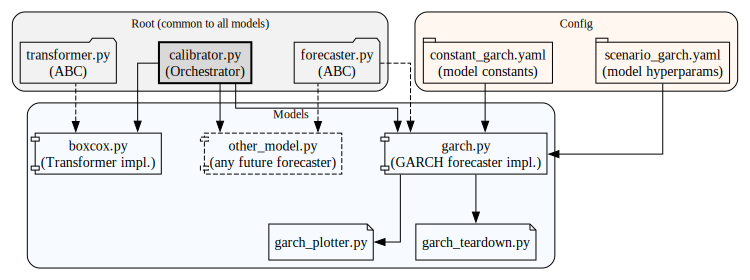

In [5]:
from graphviz import Digraph

dot = Digraph("calibration_flow_pretty", comment="Calibration System – Execution Flow")
dot.attr(rankdir="TB", splines="ortho", nodesep="0.6", ranksep="0.7", fontsize="12")

# -------- ROOT (same row) --------
with dot.subgraph(name="cluster_root") as c:
    c.attr(label="Root (common to all models)", style="rounded,filled", fillcolor="#f2f2f2")
    c.attr(rank="same")  # keep these on the same row
    c.node("CAL", "calibrator.py\n(Orchestrator)", shape="rectangle", style="filled,bold", fillcolor="#d9d9d9")
    c.node("FABC", "forecaster.py\n(ABC)", shape="folder")
    c.node("TABC", "transformer.py\n(ABC)", shape="folder")

# -------- MODELS (GARCH + placeholder for others) --------
with dot.subgraph(name="cluster_models") as m:
    m.attr(label="Models", style="rounded,filled", fillcolor="#f7fbff")
    # GARCH implementation & helpers (use your file names)
    m.node("GMODEL", "garch.py\n(GARCH forecaster impl.)", shape="component")
    m.node("BOX", "boxcox.py\n(Transformer impl.)", shape="component")
    m.node("GPLOT", "garch_plotter.py", shape="note")
    m.node("GTD", "garch_teardown.py", shape="note")
    # Optional placeholder to show other models can plug in
    m.node("OTHER", "other_model.py\n(any future forecaster)", shape="component", style="dashed")

# -------- CONFIG --------
with dot.subgraph(name="cluster_cfg") as cfg:
    cfg.attr(label="Config", style="rounded,filled", fillcolor="#fff7f0")
    cfg.node("SCEN", "scenario_garch.yaml\n(model hyperparams)", shape="tab")
    cfg.node("CONST", "constant_garch.yaml\n(model constants)", shape="tab")

# -------- FLOW (no labels on edges) --------
# Calibrator calls concrete implementations
dot.edge("CAL", "BOX")
dot.edge("CAL", "GMODEL")
dot.edge("CAL", "OTHER")

# Implementations inherit from ABCs (dashed, reversed arrow to indicate "implements")
dot.edge("GMODEL", "FABC", dir="back", style="dashed")
dot.edge("BOX", "TABC", dir="back", style="dashed")
dot.edge("OTHER", "FABC", dir="back", style="dashed")

# Config feeds the GARCH implementation
dot.edge("SCEN", "GMODEL")
dot.edge("CONST", "GMODEL")

# Model outputs to plotting/teardown
dot.edge("GMODEL", "GPLOT")
dot.edge("GMODEL", "GTD")

dot  # renders inline



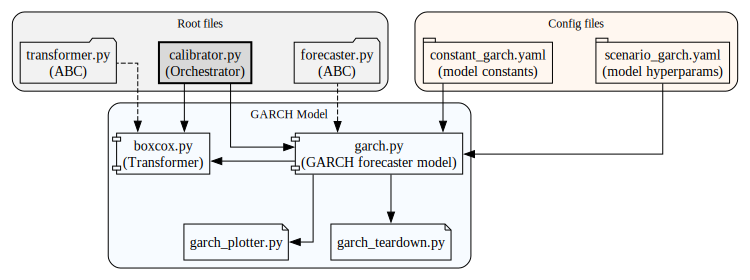

In [6]:
from graphviz import Digraph

dot = Digraph("calibration_flow_pretty", comment="Calibration System – Execution Flow")
dot.attr(rankdir="TB", splines="ortho", nodesep="0.6", ranksep="0.7", fontsize="12")

# -------- ROOT (same row) --------
with dot.subgraph(name="cluster_root") as c:
    c.attr(label="Root files", style="rounded,filled", fillcolor="#f2f2f2")
    c.attr(rank="same")  # keep these on the same row
    c.node("CAL", "calibrator.py\n(Orchestrator)", shape="rectangle", style="filled,bold", fillcolor="#d9d9d9")
    c.node("FABC", "forecaster.py\n(ABC)", shape="folder")
    c.node("TABC", "transformer.py\n(ABC)", shape="folder")

# -------- MODELS (GARCH only) --------
with dot.subgraph(name="cluster_models") as m:
    m.attr(label="GARCH Model", style="rounded,filled", fillcolor="#f7fbff")
    # GARCH implementation & helpers
    m.node("GMODEL", "garch.py\n(GARCH forecaster model)", shape="component")
    m.node("BOX", "boxcox.py\n(Transformer)", shape="component")
    m.node("GPLOT", "garch_plotter.py", shape="note")
    m.node("GTD", "garch_teardown.py", shape="note")

# -------- CONFIG --------
with dot.subgraph(name="cluster_cfg") as cfg:
    cfg.attr(label="Config files", style="rounded,filled", fillcolor="#fff7f0")
    cfg.node("SCEN", "scenario_garch.yaml\n(model hyperparams)", shape="tab")
    cfg.node("CONST", "constant_garch.yaml\n(model constants)", shape="tab")

# -------- FLOW (no labels on edges) --------
# Calibrator calls concrete implementations
dot.edge("CAL", "BOX")
dot.edge("CAL", "GMODEL")

# Implementations inherit from ABCs (dashed, reversed arrow to indicate "implements")
dot.edge("GMODEL", "FABC", dir="back", style="dashed")
dot.edge("BOX", "TABC", dir="back", style="dashed")

# Config feeds the GARCH implementation
dot.edge("SCEN", "GMODEL")
dot.edge("CONST", "GMODEL")

# Model outputs to plotting/teardown
dot.edge("GMODEL", "GPLOT")
dot.edge("GMODEL", "GTD")

# NEW: garch.py → boxcox.py (without crossing labels)
dot.edge("GMODEL", "BOX", constraint="false", minlen="2")

dot  # renders inline


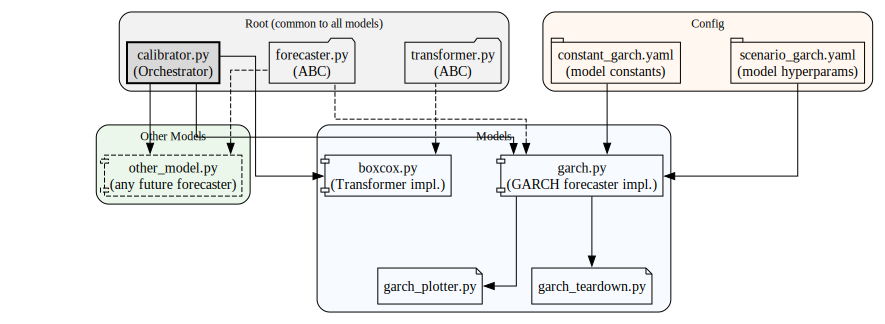

In [3]:
from graphviz import Digraph

dot = Digraph("calibration_flow_pretty", comment="Calibration System – Execution Flow")
dot.attr(rankdir="TB", splines="ortho", nodesep="0.7", ranksep="1.0", fontsize="12")

# -------- ROOT (top-left, grey) --------
with dot.subgraph(name="cluster_root") as c:
    c.attr(label="Root (common to all models)", style="rounded,filled", fillcolor="#f2f2f2")
    c.node("ROOT_A", shape="point", width="0", height="0", label="")   # anchor
    # order roughly matches vertical relationships
    c.node("CAL",  "calibrator.py\n(Orchestrator)", shape="rectangle", style="filled,bold", fillcolor="#d9d9d9")
    c.node("FABC", "forecaster.py\n(ABC)", shape="folder")
    c.node("TABC", "transformer.py\n(ABC)", shape="folder")

# -------- CONFIG (top-right, orange) --------
with dot.subgraph(name="cluster_cfg") as cfg:
    cfg.attr(label="Config", style="rounded,filled", fillcolor="#fff7f0")
    cfg.node("CFG_A", shape="point", width="0", height="0", label="")   # anchor
    cfg.node("SCEN",  "scenario_garch.yaml\n(model hyperparams)", shape="tab")
    cfg.node("CONST", "constant_garch.yaml\n(model constants)", shape="tab")

# -------- OTHER MODELS (bottom-left, green) --------
with dot.subgraph(name="cluster_other") as o:
    o.attr(label="Other Models", style="rounded,filled", fillcolor="#eaf7ea")
    o.node("OTHER_A", shape="point", width="0", height="0", label="")    # anchor
    o.node("OTHER", "other_model.py\n(any future forecaster)", shape="component", style="dashed")

# -------- MODELS (bottom-right, blue) --------
with dot.subgraph(name="cluster_models") as m:
    m.attr(label="Models", style="rounded,filled", fillcolor="#f7fbff")
    m.node("MOD_A", shape="point", width="0", height="0", label="")      # anchor
    m.node("GMODEL", "garch.py\n(GARCH forecaster impl.)", shape="component")
    m.node("BOX",    "boxcox.py\n(Transformer impl.)", shape="component")
    m.node("GPLOT",  "garch_plotter.py", shape="note")
    m.node("GTD",    "garch_teardown.py", shape="note")

# =========================
# HARD 2×2 GRID ALIGNMENT
# =========================
# Row 1: Root — Config
with dot.subgraph() as top:
    top.attr(rank="same")
    top.node("ROOT_A"); top.node("CFG_A")
dot.edge("ROOT_A", "CFG_A", style="invis", weight="100")

# Row 2: Other Models — Models  (FLIPPED ORDER)
with dot.subgraph() as bottom:
    bottom.attr(rank="same")
    bottom.node("OTHER_A"); bottom.node("MOD_A")
dot.edge("OTHER_A", "MOD_A", style="invis", weight="100")

# Columns: Root above Other; Config above Models
dot.edge("ROOT_A", "OTHER_A", style="invis", weight="100")
dot.edge("CFG_A",  "MOD_A",   style="invis", weight="100")

# Gentle vertical nudges so edges are straighter
dot.edge("CAL",  "OTHER",  style="invis", weight="50")   # Calibrator above Other Models
dot.edge("FABC", "GMODEL", style="invis", weight="40")   # Forecaster above garch.py
dot.edge("TABC", "BOX",    style="invis", weight="40")   # Transformer above boxcox.py

# =========================
# FLOW (top→bottom edges won't move rows)
# =========================
# Calibrator calls
dot.edge("CAL", "OTHER",  constraint="false")
dot.edge("CAL", "GMODEL", constraint="false")
dot.edge("CAL", "BOX",    constraint="false")

# ABC implementations (dashed, reverse direction)
dot.edge("OTHER",  "FABC", dir="back", style="dashed", constraint="false")
dot.edge("GMODEL", "FABC", dir="back", style="dashed", constraint="false")
dot.edge("BOX",    "TABC", dir="back", style="dashed", constraint="false")

# Config feeds garch
dot.edge("SCEN",  "GMODEL", constraint="false")
dot.edge("CONST", "GMODEL", constraint="false")

# Model outputs
dot.edge("GMODEL", "GPLOT")
dot.edge("GMODEL", "GTD")

dot  # renders inline
